# Evalute MaskNet Profile R2 for different thresholds

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-03-27 08:58:26.302677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
from neural_networks.cbrain.cam_constants import *
import matplotlib.pyplot as plt
import gc
import pickle
import seaborn as sns
import pandas as pd
import numpy as np

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

In [38]:
base_dirs =(
    # "training_82_mask_net_bespoke_thresholds_spars1.0", 
    # "training_83_mask_net_bespoke_thresholds_spars0.1",
    # "training_84_mask_net_bespoke_thresholds_spars0.01",
    # "training_85_mask_net_bespoke_thresholds_spars0.001",
    # "training_86_mask_net_bespoke_thresholds_spars1e-4", 
    # "training_87_mask_net_bespoke_thresholds_spars1e-5", 
    # "training_88_mask_net_prediction_thresholds_spars1.0", 
    # "training_89_mask_net_prediction_thresholds_spars0.1", 
    # "training_90_mask_net_prediction_thresholds_spars0.01", 
    # "training_91_mask_net_prediction_thresholds_spars0.001", 
    # "training_92_mask_net_prediction_thresholds_spars1e-4", 
    # "training_93_mask_net_prediction_thresholds_spars1e-5",     
    # "training_95_mask_net_prediction_thresholds_spars1.0",
    # "training_96_mask_net_prediction_thresholds_spars0.1",
    "training_97_mask_net_prediction_thresholds_spars0.01",
    "training_98_mask_net_prediction_thresholds_spars0.001",
    "training_99_mask_net_prediction_thresholds_spars1e-4",
    # "training_100_mask_net_prediction_thresholds_spars1e-5",
)

profiles_dir = os.path.join("plots_profiles", "range-1440_lats-90_90_lons0.0_359.0_stats-")
variables = ["phq", "tphystnd"]


In [39]:
def parse_label(dir_str):
    if dir_str == os.path.join("eval_nando", "causal_single_nn", "models_arch-rasp_thrs-opt-mse6"):
        return "CausalSingleNN"
    elif dir_str == "training_74_pre_mask_net_spars0.001":
        return "PreMaskNet, lpred=0.001"
    elif dir_str =="training_75_mask_net_bespoke_thresholds":
        return "MaskNet, reference thresholds"
    elif dir_str == "training_76_mask_net_prediction_thresholds_val":
        return "MaskNet, val performance threshold"
    elif dir_str == "training_76_mask_net_prediction_thresholds_train":
        return "MaskNet, train performance threshold"
        
    elif dir_str == "training_82_mask_net_bespoke_thresholds_spars1.0":
        return "MaskNet, reference thresholds, lspars=1.0"
    elif dir_str == "training_83_mask_net_bespoke_thresholds_spars0.1":
        return "MaskNet, reference thresholds, lspars=0.1"
    elif dir_str == "training_84_mask_net_bespoke_thresholds_spars0.01":
        return "MaskNet, reference thresholds, lspars=0.01"
    elif dir_str == "training_85_mask_net_bespoke_thresholds_spars0.001":
        return "MaskNet, reference thresholds, lspars=0.001"
    elif dir_str == "training_86_mask_net_bespoke_thresholds_spars1e-4":
        return "MaskNet, reference thresholds, lspars=1e-4"
    elif dir_str == "training_87_mask_net_bespoke_thresholds_spars1e-5":
        return "MaskNet, reference thresholds, lspars=1e-5"

    elif "training_88_mask_net_prediction_thresholds_spars1.0_train" in dir_str: 
        return "MaskNet, train thresholds, ls=1.0, 1e-4-70perc"
    elif "training_88_mask_net_prediction_thresholds_spars1.0_val" in dir_str: 
        return "MaskNet, val thresholds, ls=1.0, 1e-4-70perc"
    elif "training_89_mask_net_prediction_thresholds_spars0.1_train" in dir_str: 
        return "MaskNet, train thresholds, ls=0.1, 1e-4-70perc"
    elif "training_89_mask_net_prediction_thresholds_spars0.1_val" in dir_str: 
        return "MaskNet, val thresholds, ls=0.1, 1e-4-70perc"
    elif "training_90_mask_net_prediction_thresholds_spars0.01_train" in dir_str: 
        return "MaskNet, train thresholds, ls=0.01, 1e-4-70perc"
    elif "training_90_mask_net_prediction_thresholds_spars0.01_val" in dir_str: 
        return "MaskNet, val thresholds, ls=0.01, 1e-4-70perc"
    elif "training_91_mask_net_prediction_thresholds_spars0.001_train" in dir_str: 
        return "MaskNet, train thresholds, ls=0.001, 1e-4-70perc"
    elif "training_91_mask_net_prediction_thresholds_spars0.001_val" in dir_str: 
        return "MaskNet, val thresholds, ls=0.001, 1e-4-70perc"
    elif "training_92_mask_net_prediction_thresholds_spars1e-4_train" in dir_str: 
        return "MaskNet, train thresholds, ls=1e-4, 1e-4-70perc"
    elif "training_92_mask_net_prediction_thresholds_spars1e-4_val" in dir_str: 
        return "MaskNet, val thresholds, ls=1e-4, 1e-4-70perc"
    elif "training_93_mask_net_prediction_thresholds_spars1e-5_train" in dir_str: 
        return "MaskNet, train thresholds, ls=1e-5, 1e-4-70perc"
    elif "training_93_mask_net_prediction_thresholds_spars1e-5_val" in dir_str: 
        return "MaskNet, val thresholds, ls=1e-5, 1e-4-70perc"
    elif "training_95_mask_net_prediction_thresholds_spars1.0_train" in dir_str: 
        return "MaskNet, train thresholds, ls=1.0, 20-70perc"
    elif "training_95_mask_net_prediction_thresholds_spars1.0_val" in dir_str: 
        return "MaskNet, val thresholds, ls=1.0, 20-70perc"
    elif "training_96_mask_net_prediction_thresholds_spars0.1_train" in dir_str: 
        return "MaskNet, train thresholds, ls=0.1, 20-70perc"
    elif "training_96_mask_net_prediction_thresholds_spars0.1_val" in dir_str: 
        return "MaskNet, val thresholds, ls=0.1, 20-70perc"
    elif "training_97_mask_net_prediction_thresholds_spars0.01_train" in dir_str: 
        return "MaskNet, train thresholds, ls=0.01, 20-70perc"
    elif "training_97_mask_net_prediction_thresholds_spars0.01_val" in dir_str: 
        return "MaskNet, val thresholds, ls=0.01, 20-70perc"
    elif "training_98_mask_net_prediction_thresholds_spars0.001_train" in dir_str: 
        return "MaskNet, train thresholds, ls=0.001, 20-70perc"
    elif "training_98_mask_net_prediction_thresholds_spars0.001_val" in dir_str: 
        return "MaskNet, val thresholds, ls=0.001, 20-70perc"
    elif "training_99_mask_net_prediction_thresholds_spars1e-4_train" in dir_str: 
        return "MaskNet, train thresholds, ls=1e-4, 20-70perc"
    elif "training_99_mask_net_prediction_thresholds_spars1e-4_val" in dir_str: 
        return "MaskNet, val thresholds, ls=1e-4, 20-70perc"
    elif "training_100_mask_net_prediction_thresholds_spars1e-5_train" in dir_str: 
        return "MaskNet, train thresholds, ls=1e-5, 20-70perc"
    elif "training_100_mask_net_prediction_thresholds_spars1e-5_val" in dir_str: 
        return "MaskNet, val thresholds, ls=1e-5, 20-70perc"
    else:
        raise ValueError(f"Unknown directory string {dir_str}")

In [40]:
def get_stats(s, var):
    print(f"\n\nVariable: {var}")
    
    stats_per_training = dict()
    
    for bd in base_dirs:
        if var == "phq":
            filename = f"phq_stats-{s}.p"
        elif var == "tphystnd":
            filename = f"tphystnd_stats-{s}.p"
        else:
            raise ValueError(f"Unknown value for variable: {var}")
            
        plot_dir = os.path.join(PROJECT_ROOT, "output_castle", bd, "plots_offline_evaluation")

        if "prediction_thresholds" in bd:
            for suffix in ["_val", "_train"]:
                load_dir = os.path.join(plot_dir, "plots_profiles" + suffix, "range-1440_lats-90_90_lons0.0_359.0_stats-" + s)
                
                with open(os.path.join(load_dir, filename), "rb") as f:
                    values = pickle.load(f)
                print(f"\nLoaded file: {os.path.join(load_dir, filename)}")
                
                stats_per_training[bd + suffix] = values
        else: 
            load_dir = os.path.join(plot_dir, "plots_profiles", "range-1440_lats-90_90_lons0.0_359.0_stats-" + s)   
    
            with open(os.path.join(load_dir, filename), "rb") as f:
                values = pickle.load(f)
            print(f"\nLoaded file: {os.path.join(load_dir, filename)}")
            
            stats_per_training[bd] = values
            

    return stats_per_training
        

In [41]:
def get_causal_stats(s, var):
    
    load_dir = os.path.join(PROJECT_ROOT, "output_castle", "eval_nando", "causal_single_nn", 
                            "models_arch-rasp_thrs-opt-mse6", "plots_offline_evaluation", profiles_dir + s)

    if var == "phq":
        filename = f"phq_stats-{s}.p"
    elif var == "tphystnd":
        filename = f"tphystnd_stats-{s}.p"
    else:
        raise ValueError(f"Unknown value for variable: {var}")

    with open(os.path.join(load_dir, filename), "rb") as f:
        values = pickle.load(f)
        
    return values
        

In [42]:
def get_single_stats(s, var):
    load_dir = os.path.join(PROJECT_ROOT, "output_castle", "training_94_single_nn", 
                                "plots_offline_evaluation", profiles_dir + s)

    if var == "phq":
        filename = f"phq_stats-{s}.p"
    elif var == "tphystnd":
        filename = f"tphystnd_stats-{s}.p"
    else:
        raise ValueError(f"Unknown value for variable: {var}")

    with open(os.path.join(load_dir, filename), "rb") as f:
        values = pickle.load(f)
        
    return values

In [43]:
phq_r2 = get_stats("r2", variables[0])
tphystnd_r2 = get_stats("r2", variables[1])

causal_phq_r2 = get_causal_stats("r2",  variables[0])
causal_tphystnd_r2 = get_causal_stats("r2",  variables[1])

single_phq_r2 = get_single_stats("r2",  variables[0])
single_tphystnd_r2 = get_single_stats("r2",  variables[1])



Variable: phq

Loaded file: /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_97_mask_net_prediction_thresholds_spars0.01/plots_offline_evaluation/plots_profiles_val/range-1440_lats-90_90_lons0.0_359.0_stats-r2/phq_stats-r2.p

Loaded file: /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_97_mask_net_prediction_thresholds_spars0.01/plots_offline_evaluation/plots_profiles_train/range-1440_lats-90_90_lons0.0_359.0_stats-r2/phq_stats-r2.p

Loaded file: /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_98_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_profiles_val/range-1440_lats-90_90_lons0.0_359.0_stats-r2/phq_stats-r2.p

Loaded file: /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_98_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_profiles_train/range-1440_lats-90_90_lons0.0_359.0_stats-r2/phq_stats-r2.p

Loaded file: /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_99_mask_net_prediction_thresholds_sp

In [56]:

def plot_profile_stats(profile_stats, var, s, save_dir=""):
    fig, ax = plt.subplots(figsize=(10, 8))

    sns.set_style("whitegrid")
    sns.set_palette("colorblind", n_colors=len(profile_stats)+1)


    for i, (x, y, key) in enumerate(zip([np.mean(r, axis=1) for r in profile_stats.values()], 
                                        [P for i in range(len(profile_stats))], profile_stats.keys())):
        select_train_val = "_val"
        
        if select_train_val in key:
            label = parse_label(key)
            
            sns.lineplot(
                x=x,
                y=y, 
                ax=ax,
                label=label,
                estimator=None, sort=False)

    if var == "phq":
        causal_x = np.mean(causal_phq_r2, axis=1)
        single_x = np.mean(single_phq_r2, axis=1)
    elif var == "tphystnd":
        causal_x = np.mean(causal_tphystnd_r2, axis=1)
        single_x = np.mean(single_tphystnd_r2, axis=1)
    else:
        raise ValueError(f"Unknown value for variable: {var}")

    # plot causal single nn
    sns.lineplot(
        x=causal_x,
        y=P, 
        ax=ax,
        label="CausalSingleNN",
        linestyle='dashed', 
        estimator=None, sort=False)
    # plot single nn
    sns.lineplot(
        x=single_x,
        y=P, 
        ax=ax,
        label="SingleNN",
        linestyle='dotted', 
        estimator=None, sort=False)

    ax.invert_yaxis()
    ax.set_xlim([-0.05, 1.0])

    ax.set_ylabel('Pressure (hPa)', labelpad=15, color='#333333')
    ax.set_xlabel(f"{s}", labelpad=15, color='#333333')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_color('#DDDDDD')
    
    # handles, labels = ax.get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys(), loc=0)
    
    ax.legend(title='Network configuration', loc='lower right')

    ax.set_title(f"Training {s} for variable {var}", pad=15, color='#333333', weight='bold', fontsize=12)
    
    
    fig.show()    # fig.tight_layout()
    
    if save_dir != "":
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        
        name = f"manual_tuning_profile_stats_{var}_{s}{select_train_val}.png"

        plt.savefig(os.path.join(output_dir, name), dpi=400, bbox_inches="tight")
        print(f'\nSaving results plot {name}.')
        
        
    

In [57]:
base_dirs

('training_97_mask_net_prediction_thresholds_spars0.01',
 'training_98_mask_net_prediction_thresholds_spars0.001',
 'training_99_mask_net_prediction_thresholds_spars1e-4')

In [58]:
base_output_dir = os.path.join(PROJECT_ROOT, "output_castle", base_dirs[1], 
                              "plots_offline_evaluation", "profile_r2_comparison")
print(base_output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output_castle/training_98_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/profile_r2_comparison


FigureCanvasAgg is non-interactive, and thus cannot be shown



Saving results plot manual_tuning_profile_stats_phq_r2_val.png.


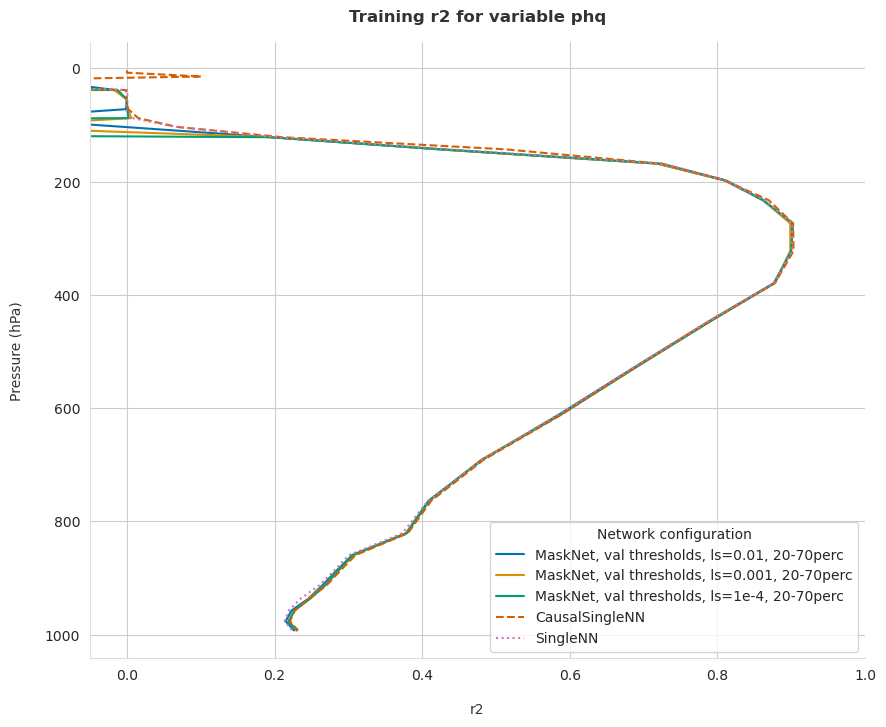

In [59]:
output_dir = os.path.join(base_output_dir, "profiles_select")
plot_profile_stats(phq_r2, variables[0], "r2", save_dir=output_dir)

FigureCanvasAgg is non-interactive, and thus cannot be shown



Saving results plot manual_tuning_profile_stats_tphystnd_r2_val.png.


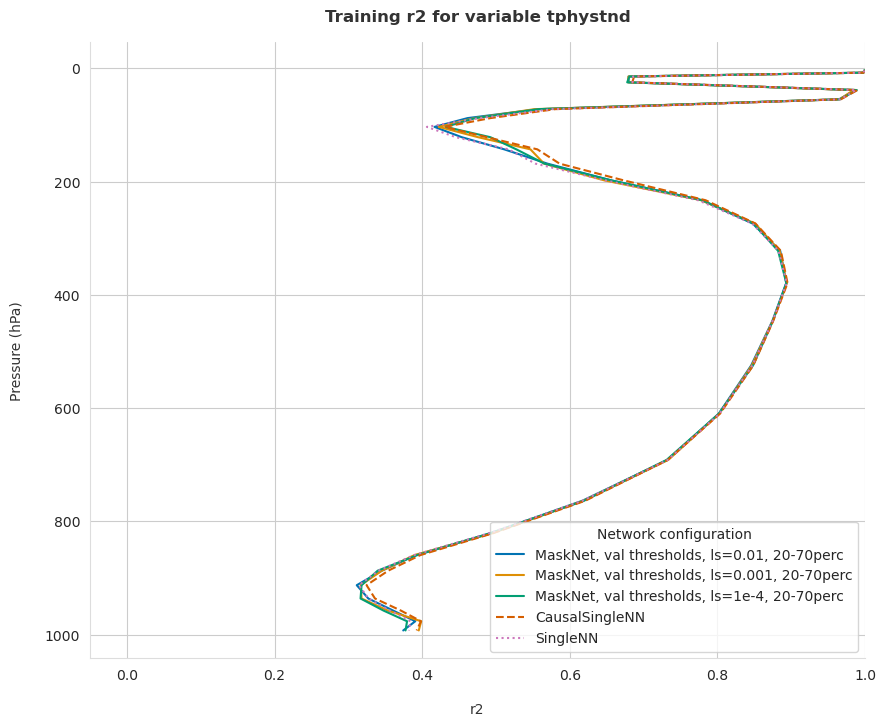

In [60]:

output_dir = os.path.join(base_output_dir, "profiles_select")
plot_profile_stats(tphystnd_r2, variables[1], "r2", save_dir=output_dir)